# Real Estate Market Analysis: Alberta, Canada

**For my analysis and the development of a predictive pricing model, I utilized the following datasets:**

1. **Provincial GDP Statistics** - to assess the overall economic health and its influence on the real estate market. [Data Source](https://economicdashboard.alberta.ca/dashboard/gdp-at-basic-prices)
2. **Refinancing Interest Rate (%)** - to evaluate how borrowing costs impact housing demand and affordability. [Data Source](https://wowa.ca/bank-of-canada-interest-rate)
3. **Consumer price index** - as an indicator of purchasing power and cost-of-living changes that affect real estate trends. [Data Source](https://economicdashboard.alberta.ca/dashboard/consumer-price-index)
4. **Unemployment Data by Age Groups** - to identify workforce dynamics and their correlation with housing needs. [Data Source](https://economicdashboard.alberta.ca/dashboard/unemployment-rate)
5. **Housing Starts** - data on the initiation of residential construction, indicating the number of new housing units that began construction in a given period. [Data Source](https://economicdashboard.alberta.ca/dashboard/housing-starts/)
6. **Migration Data in Alberta** - to understand population shifts and their effect on housing demand and regional market dynamics. [Data Source](https://economicdashboard.alberta.ca/dashboard/net-migration/)
7. **Housing Price Statistics for the Last 20 Years** - to analyze historical price trends and their implications for future market movements. [Data Source](https://creastats.crea.ca/en-CA/)
8. **Current Real Estate Prices** - (more then 5000 properties) from Canada's largest real estate website, realtor.ca, to get the latest market prices and trends. [Data Source](https://www.realtor.ca/map#ZoomLevel=10&Center=51.028188%2C-114.086920&LatitudeMax=51.34109&LongitudeMax=-113.18604&LatitudeMin=50.71316&LongitudeMin=-114.98780&Sort=6-D&PGeoIds=g30_c3nfkdtg&GeoIds=g30_c3nfkdtg&GeoName=Calgary%2C%20AB&PropertyTypeGroupID=1&TransactionTypeId=2&PropertySearchTypeId=0&Currency=CAD&HiddenListingIds=&IncludeHiddenListings=false)

These datasets provided a comprehensive foundation for analyzing market conditions and building a robust model to predict real estate price trends.

In [27]:
# Required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import contextily as ctx
from shapely.geometry import Point
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

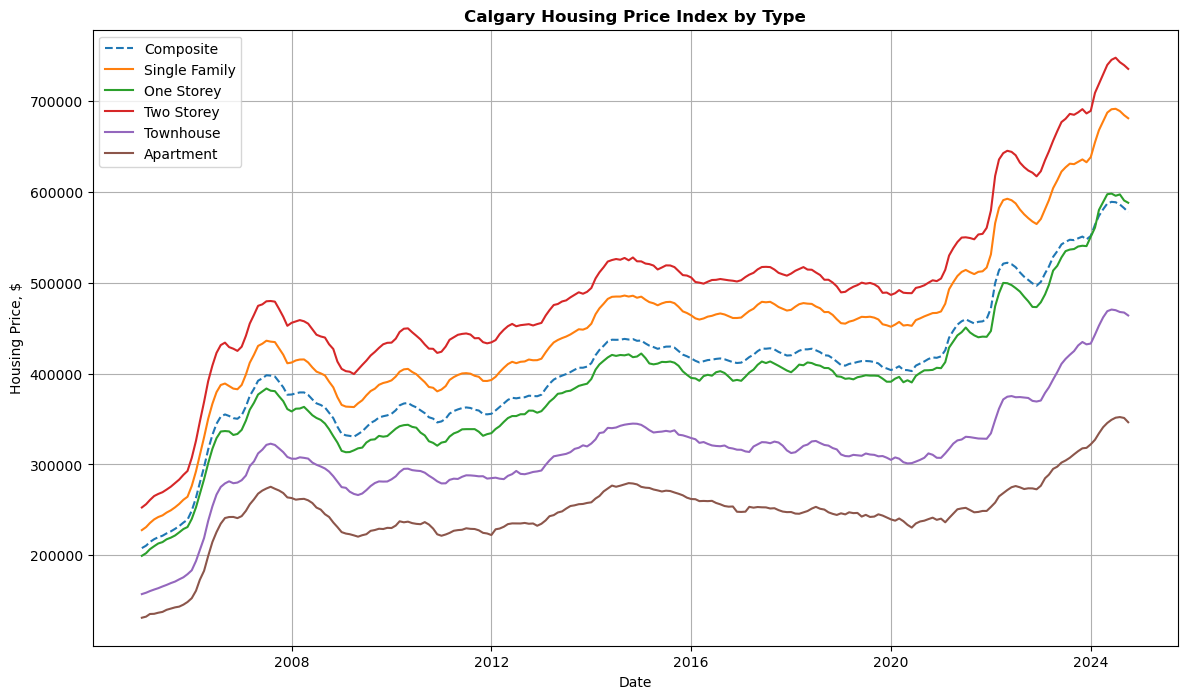

In [6]:
# Building a plot for housing price statistics by type

housing_price_df = pd.read_csv('data_source/CalgaryHousingPriceStatistics.csv', delimiter=';', parse_dates=['Date'], dayfirst=True)

for column in housing_price_df.columns[1:]:
    housing_price_df[column] = housing_price_df[column].astype(str).str.replace(',', '.').astype(float)

plt.figure(figsize=(14, 8))
plt.plot(housing_price_df['Date'], housing_price_df['Composite_Benchmark'], label='Composite', linestyle='--')
plt.plot(housing_price_df['Date'], housing_price_df['Single_Family_Benchmark'], label='Single Family')
plt.plot(housing_price_df['Date'], housing_price_df['One_Storey_Benchmark'], label='One Storey')
plt.plot(housing_price_df['Date'], housing_price_df['Two_Storey_Benchmark'], label='Two Storey')
plt.plot(housing_price_df['Date'], housing_price_df['Townhouse_Benchmark'], label='Townhouse')
plt.plot(housing_price_df['Date'], housing_price_df['Apartment_Benchmark'], label='Apartment')

plt.title('Calgary Housing Price Index by Type', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Housing Price, $')
plt.legend()
plt.grid(True)
plt.show()

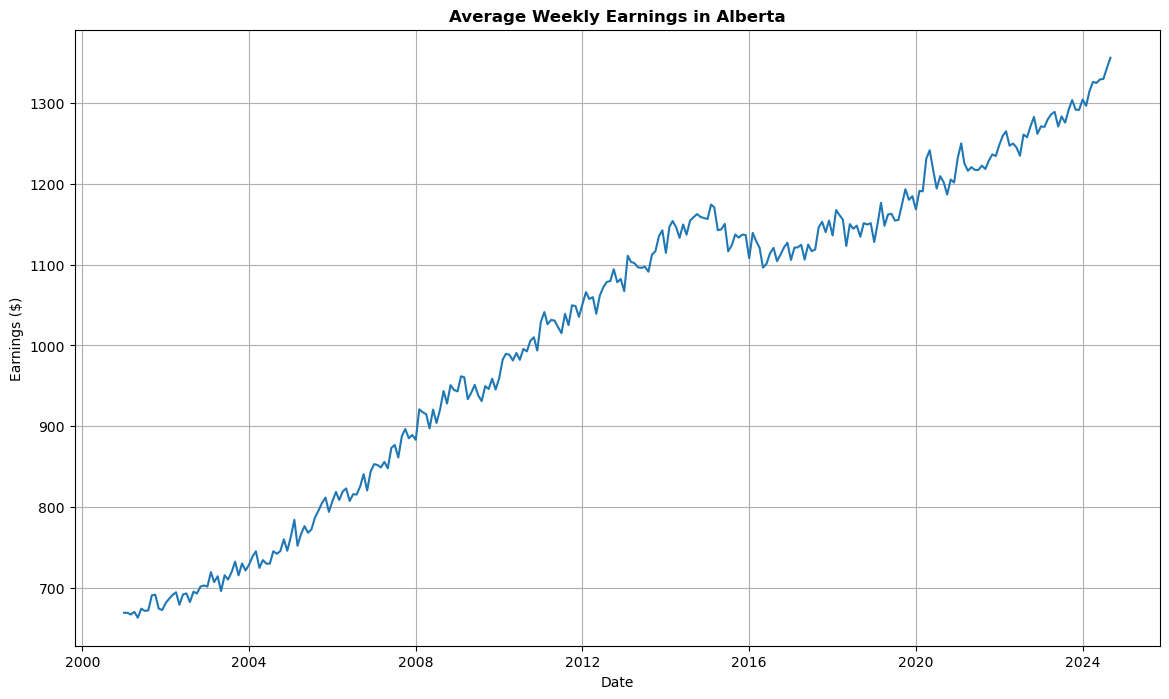

In [7]:
# Building a plot for the average weekly earnings in Alberta

earnings_df = pd.read_csv('data_source/AlbertaAverageWeeklyEarnings.csv', parse_dates=['Date'])

plt.figure(figsize=(14, 8))
plt.plot(earnings_df['Date'], earnings_df['Value'])

plt.title('Average Weekly Earnings in Alberta', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Earnings ($)')
plt.grid(True)
plt.show()

In [8]:
# Preprocessing the real estate data

real_estate_df = pd.read_csv(r'data_source/real_estate_20241016.csv')
unique_types_of_properties = real_estate_df['Type'].dropna().unique()

real_estate_df['AreaUnformatted'] = real_estate_df['AreaUnformatted'].str.extract(r'(\d+\.?\d*)').astype(float)
real_estate_df['AreaMeters'] = real_estate_df['AreaUnformatted'] * 0.092903

real_estate_df.head()

,Id,MlsNumber,BathroomTotal,Bedrooms,SizeInterior,StoriesTotal,Type,AreaUnformatted,HalfBathTotal,PriceUnformattedValue,Longitude,Latitude,AreaMeters
0,27544119,A2173223,1.0,1 + 0,618.7 sqft,3.0,Apartment,619.0,0.0,200000.0,-114.159416,51.083349,57.506957
1,27544017,A2173030,2.0,3 + 0,833 sqft,5.0,Apartment,833.0,0.0,419900.0,-113.962345,51.147714,77.388199
2,27544015,A2172046,3.0,3 + 0,1648.7 sqft,2.0,House,1649.0,1.0,599900.0,-114.054039,51.172134,153.197047
3,27544014,A2173256,2.0,3 + 0,917 sqft,2.0,Row / Townhouse,917.0,0.0,369999.0,-114.154074,51.103757,85.192051
4,27544013,A2173238,2.0,3 + 2,1125 sqft,1.0,House,1125.0,0.0,889900.0,-114.068233,51.011908,104.515875


**Single-detached units**

These are individual houses that are not attached to any other building. They have open space on all sides and do not have other dwellings above or below. This is the most common type of housing in Canada, accounting for 52.6% of all dwelling units.

**Semi-detached units**

This is one of two dwellings attached side by side. They have no dwellings above or below, and both units together have open space on all sides. Semi-detached houses make up 5% of dwelling units in Canada.

**Row units**

This is one of three or more dwellings joined side by side (or occasionally side to back), such as townhouses. They account for 6.5% of dwelling units in Canada.

**Apartment units**

There are several types of apartments:
- Apartments in duplexes: 5.5% of dwelling units
- Apartments in buildings with fewer than 5 storeys: 18.3%
- Apartments in buildings with 5 or more storeys: 10.7%

**Other unit types**

Other single-attached houses: 
- 0.2% of dwelling units
- Movable dwellings: 1.3%

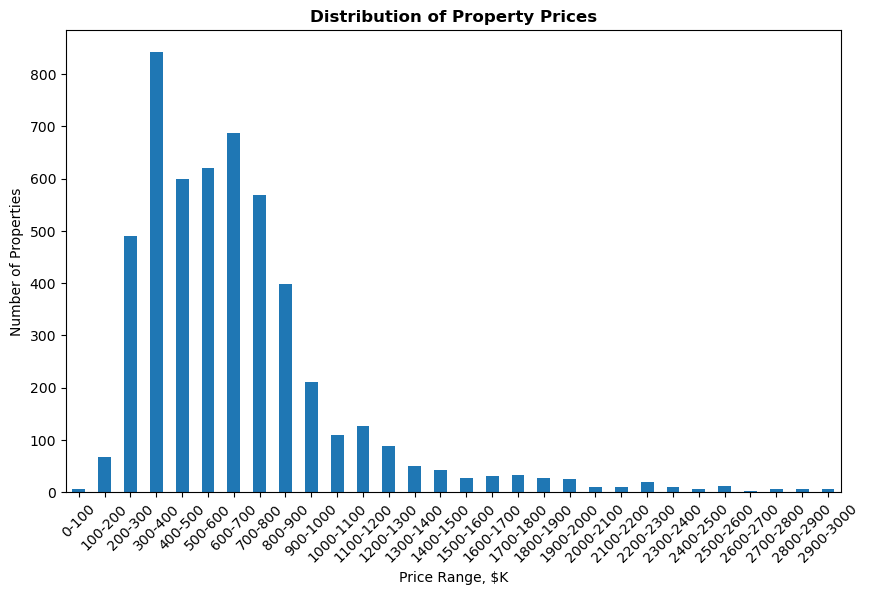

In [9]:
# Building distribution of property prices

prices = real_estate_df['PriceUnformattedValue']

# I want to get most popular price ranges. Therefore I slice data prices (0 < x < 3M)
bins = range(0, 3000001, 100000)
labels = [f'{i}-{i+100000}' for i in bins[:-1]]
new_labels = [f'{int(label.split("-")[0])//1000}-{int(label.split("-")[1])//1000}' for label in labels]

real_estate_df['PriceRange'] = pd.cut(prices, bins=bins, labels=new_labels, right=False)

price_counts = real_estate_df['PriceRange'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
price_counts.plot(kind='bar')
plt.xlabel('Price Range, $K')
plt.ylabel('Number of Properties')
plt.title('Distribution of Property Prices', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

In [10]:
unique_types = real_estate_df['Type'].unique()
print(unique_types)

['Apartment' 'House' 'Row / Townhouse' 'Duplex' 'Mobile Home'
 'Multi-Family' nan 'Manufactured Home']


In [28]:
# Building Maps by Property Types

geometry = [Point(xy) for xy in zip(real_estate_df['Longitude'], real_estate_df['Latitude'])]
real_estate_gdf = gpd.GeoDataFrame(real_estate_df, geometry=geometry)
real_estate_gdf.set_crs(epsg=4326, inplace=True)
real_estate_gdf = real_estate_gdf.to_crs(epsg=3857)

html_content = '<div style="display: flex; flex-wrap: wrap;">'
os.makedirs('images', exist_ok=True)

for property_type in unique_types_of_properties:
    sanitized_property_type = property_type.replace(" ", "_").replace("/", "_")
    fig, ax = plt.subplots(figsize=(5, 5))
    type_gdf = real_estate_gdf[real_estate_gdf['Type'] == property_type]
    type_gdf.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.5)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(f'{property_type}', fontweight='bold')
    ax.set_axis_off()
    small_image_path = os.path.join('images', f'{sanitized_property_type}_small.png')
    plt.savefig(small_image_path, bbox_inches='tight')
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    type_gdf.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.5)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(f'Real Estate ({property_type}) in Calgary', fontweight='bold')
    ax.set_axis_off()
    large_image_path = os.path.join('images', f'{sanitized_property_type}_large.png')
    plt.savefig(large_image_path, bbox_inches='tight')
    plt.close(fig)
    
    html_content += f'<a href="{large_image_path}" target="_blank">' \
        f'<img src="{small_image_path}" style="margin: 10px; height: 200px; width: auto;"></a>'

html_content += '</div>'

display(HTML(html_content))

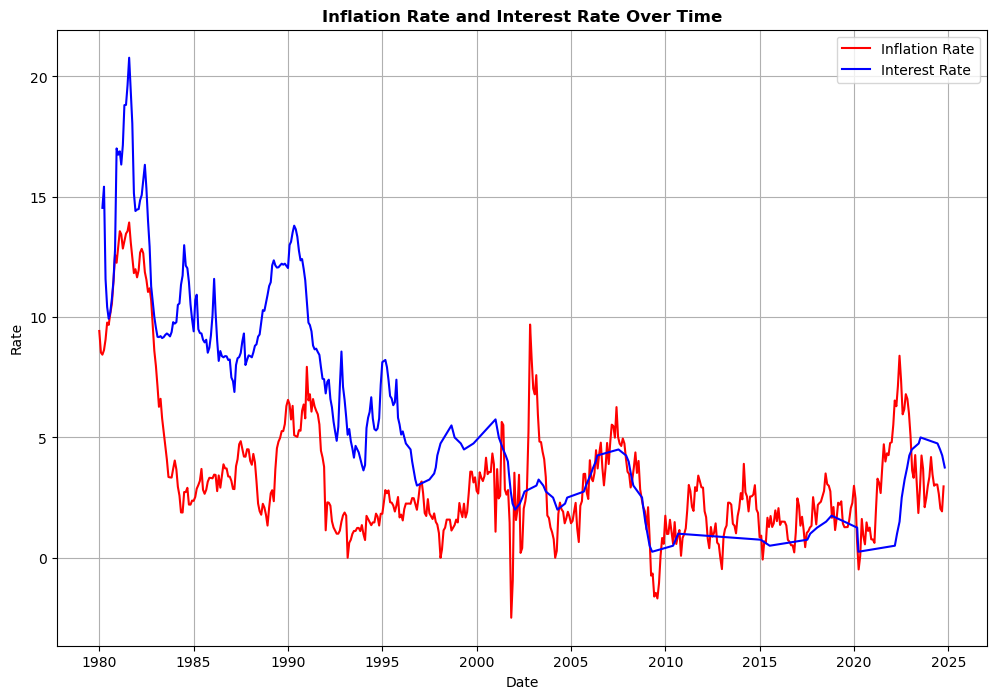

In [12]:
# Building Inflation and Interest Rate Over Time

inflation_df = pd.read_csv('data_source/AlbertaConsumerPriceIndex.csv', parse_dates=['Date'])
rate_history_df = pd.read_csv('data_source/BankofCanadaRateHistory.csv', parse_dates=['Date'], dayfirst=True)

inflation_df['Value'] = inflation_df['Value'] * 100
inflation_df = inflation_df[inflation_df['Date'].dt.year >= 1980]
rate_history_df = rate_history_df[rate_history_df['Date'].dt.year >= 1980]

plt.figure(figsize=(12, 8))
plt.plot(inflation_df['Date'], inflation_df['Value'], color='red', label='Inflation Rate')
plt.plot(rate_history_df['Date'], rate_history_df['Bank of Canada Target Overnight Rate'], color='blue', label='Interest Rate')

plt.title('Inflation Rate and Interest Rate Over Time', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()

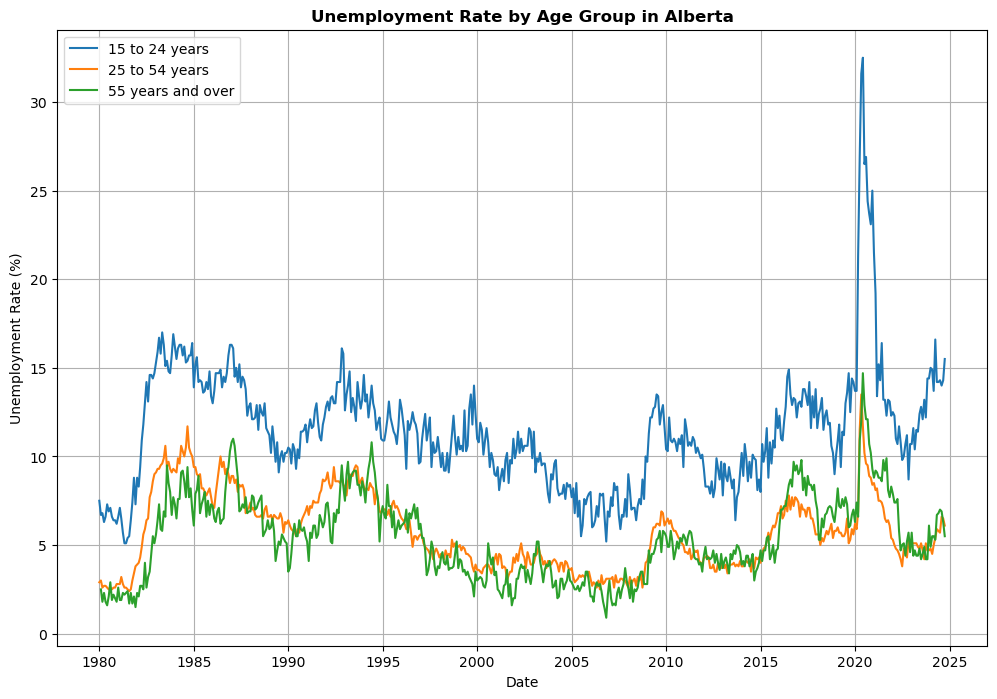

In [13]:
# Building Unemployment Rate by Age Group

unemployment_df = pd.read_csv('data_source/AlbertaUnemploymentRate.csv', parse_dates=['Date'])
unemployment_df = unemployment_df[unemployment_df['Date'].dt.year >= 1980]

age_groups = unemployment_df['Series'].unique()

plt.figure(figsize=(12, 8))
for age_group in age_groups:
    filtered_data = unemployment_df[unemployment_df['Series'] == age_group]
    plt.plot(filtered_data['Date'], filtered_data['Value'], label=age_group)

plt.title('Unemployment Rate by Age Group in Alberta', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

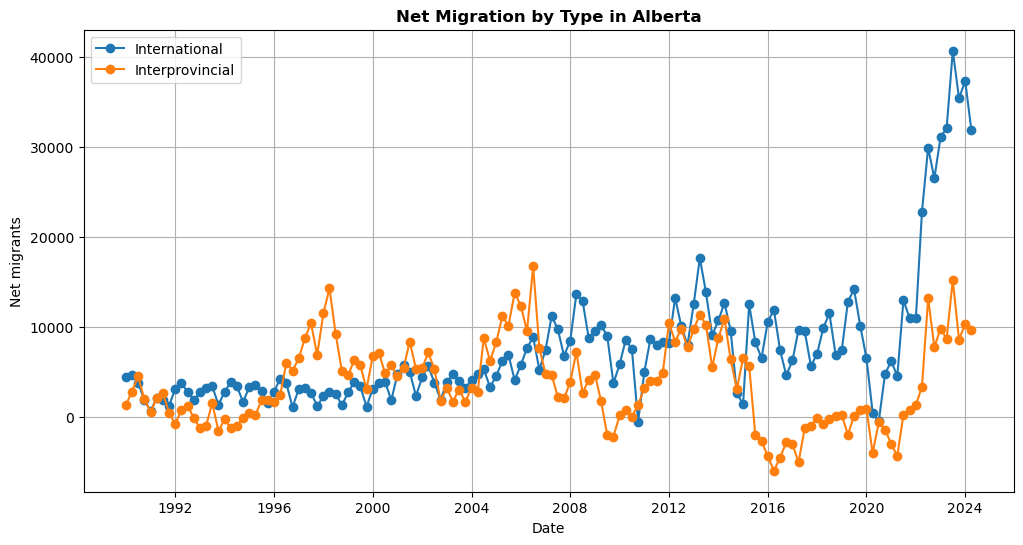

In [14]:
# Building the plot for net migration by type

migration_df = pd.read_csv(r'data_source/AlbertaNetMigrationbyType.csv')

migration_df['Date'] = pd.to_datetime(migration_df['Date'], format='ISO8601')
migration_df = migration_df.pivot(index='Date', columns='Type', values='Value')
migration_df = migration_df.reset_index()
migration_df = migration_df[migration_df['Date'].dt.year >= 1990]
migration_df = migration_df.drop(columns=['Total migration'])

plt.figure(figsize=(12, 6))

for column in migration_df.columns[1:]:
    plt.plot(migration_df['Date'], migration_df[column], marker='o', label=column)

plt.title('Net Migration by Type in Alberta', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Net migrants')
plt.legend()
plt.grid(True)
plt.show()

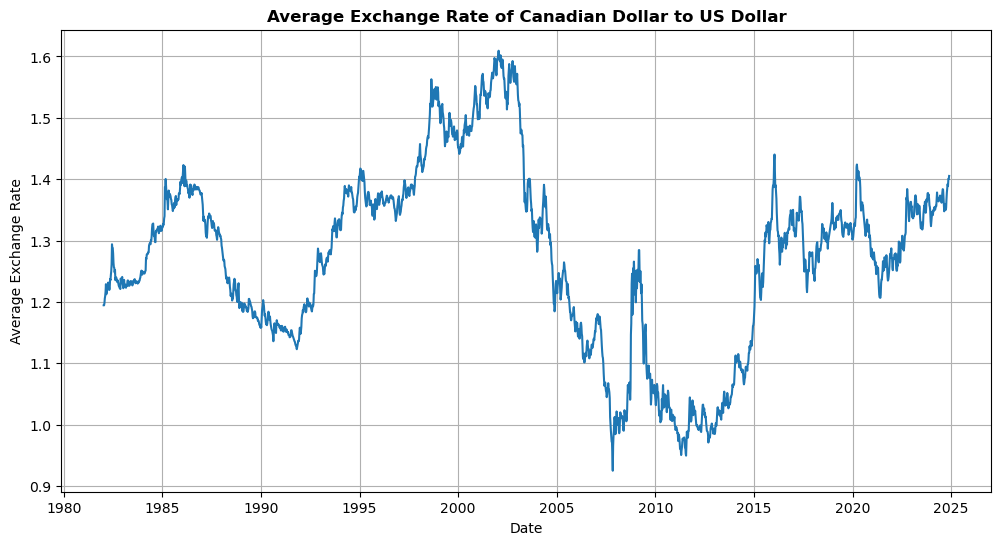

In [15]:
# Build a plot of the average exchange rate of Canadian Dollar to US Dollar

currency_df = pd.read_csv('data_source/CanadaCurrencyStats.csv', parse_dates=['rowDate'])
currency_df['average_rate'] = (currency_df['last_max'] + currency_df['last_min']) / 2

plt.figure(figsize=(12, 6))
plt.plot(currency_df['rowDate'], currency_df['average_rate'])

plt.title('Average Exchange Rate of Canadian Dollar to US Dollar', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Average Exchange Rate')
plt.grid(True)
plt.show()

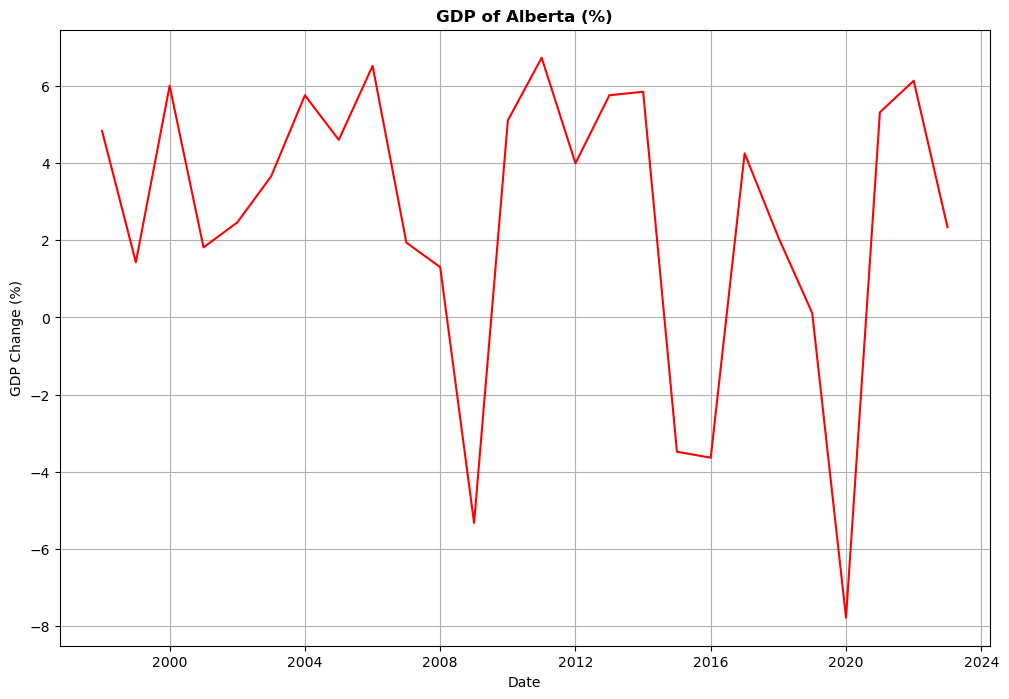

In [16]:
# Building the plot for GDP of Alberta

gdp_df = pd.read_csv('data_source/AlbertaGDPRate.csv', parse_dates=['Date'])
gdp_df['GDP Change (%)'] = gdp_df['Value'].pct_change() * 100

plt.figure(figsize=(12, 8))
plt.plot(gdp_df['Date'], gdp_df['GDP Change (%)'], color='red')
plt.xlabel('Date')
plt.ylabel('GDP Change (%)')
plt.title('GDP of Alberta (%)', fontweight='bold')
plt.grid(True)
plt.show()

<Figure size 4400x800 with 0 Axes>

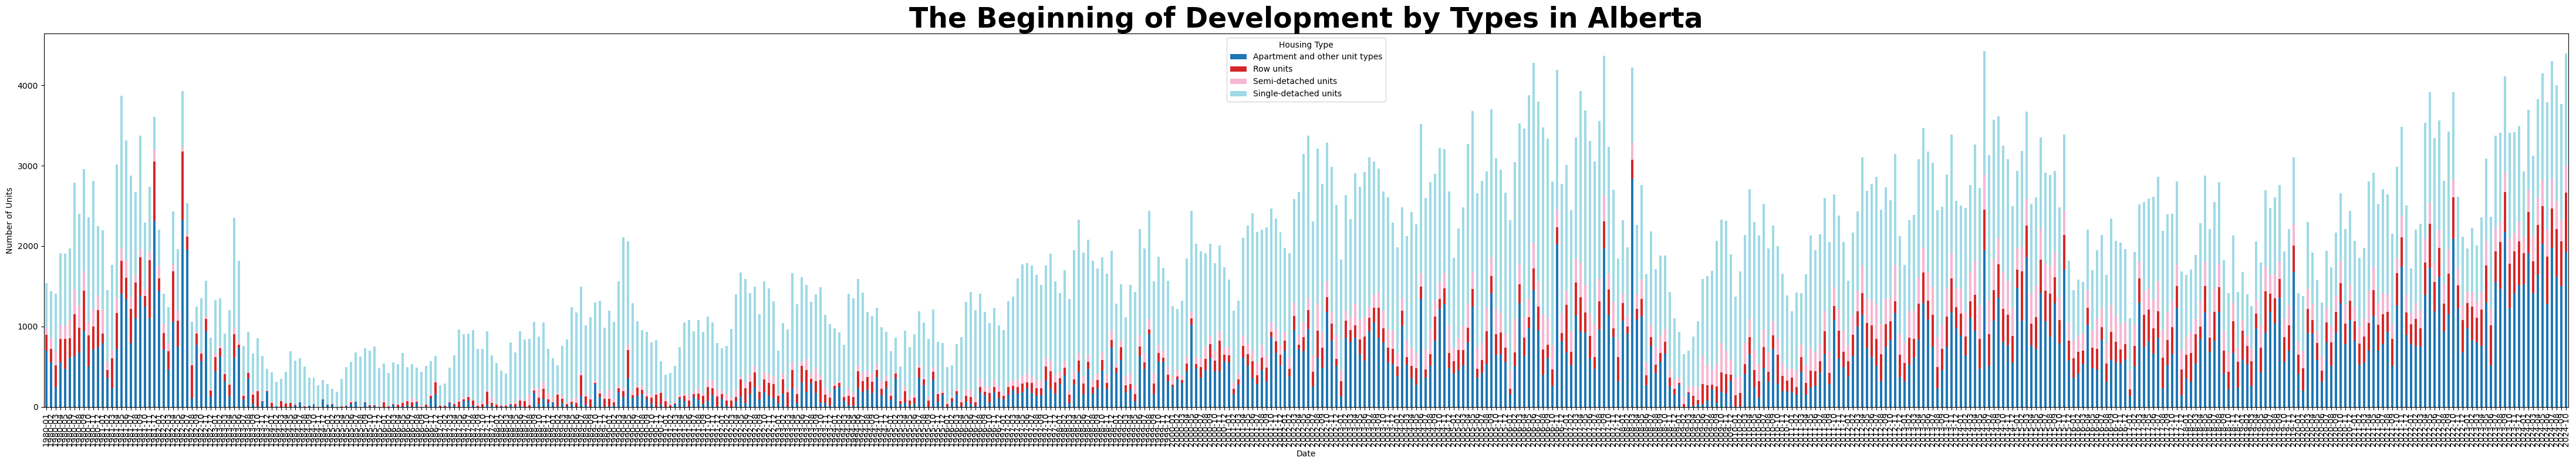

In [17]:
# Building a plot for housing starts by type

housing_starts_df = pd.read_csv('data_source/AlbertaHousingStarts.csv', parse_dates=['Date'])
housing_starts_df = housing_starts_df[~housing_starts_df['Type'].isin(['Total units', 'Multiples'])]
housing_starts_df = housing_starts_df[housing_starts_df['Date'].dt.year >= 1980]
housing_starts_df['YearMonth'] = housing_starts_df['Date'].dt.to_period('M')
grouped_data = housing_starts_df.groupby(['YearMonth', 'Type'])['Value'].sum().unstack(fill_value=0)

num_months = len(grouped_data.index)
fig_width = max(14, num_months // 12)
plt.figure(figsize=(fig_width, 8))
grouped_data.plot(kind='bar', stacked=True, figsize=(fig_width, 8), colormap='tab20')

plt.title('The Beginning of Development by Types in Alberta', fontweight='bold', fontsize=34)
plt.xlabel('Date')
plt.ylabel('Number of Units')
plt.legend(title='Housing Type')
plt.tight_layout()
plt.show()

In [18]:
# Merging the data

gdp_df_filtered = gdp_df[gdp_df['Date'].dt.year >= 2005][['Date', 'GDP Change (%)']]

housing_price_df_filtered = housing_price_df[housing_price_df['Date'].dt.year >= 2005][['Date', 'Single_Family_Benchmark', 'Two_Storey_Benchmark', 'Apartment_Benchmark', 'One_Storey_Benchmark', 'Townhouse_Benchmark']]

inflation_df_filtred = inflation_df[inflation_df['Date'].dt.year >= 2005][['Date', 'Value']]
inflation_df_filtred.rename(columns={'Value': 'Inflation Rate'}, inplace=True)
inflation_df_filtred['Date'] = inflation_df_filtred['Date'].dt.to_period('M').dt.to_timestamp()

rate_history_df_filtred = rate_history_df[rate_history_df['Date'] >= '2004-10-01'][['Date', 'Bank of Canada Target Overnight Rate']]
rate_history_df_filtred.rename(columns={'Bank of Canada Target Overnight Rate': 'Interest Rate'}, inplace=True)
rate_history_df_filtred['Date'] = rate_history_df_filtred['Date'].dt.to_period('M').dt.to_timestamp()

unemployment_df_filtered = unemployment_df[(unemployment_df['Date'].dt.year >= 2005) & (unemployment_df['Series'] == '25 to 54 years')][['Date', 'Value']]
unemployment_df_filtered.rename(columns={'Value': 'Unemployment Rate'}, inplace=True)

migration_df_filtered = migration_df[migration_df['Date'].dt.year >= 2005]
migration_df_filtered = migration_df_filtered.sort_values(by='Date')
migration_df_filtered['Date'] = migration_df_filtered.apply(lambda row: pd.date_range(start=row['Date'], periods=3, freq='MS'), axis=1)
migration_df_filtered = migration_df_filtered.explode('Date').reset_index(drop=True)
migration_df_filtered['International'] = migration_df_filtered['International'] // 3
migration_df_filtered['Interprovincial'] = migration_df_filtered['Interprovincial'] // 3

currency_df_filtered = currency_df[currency_df['rowDate'] >= '2004-12-26'][['rowDate', 'average_rate']]
average_monthly_rate = currency_df_filtered.groupby(currency_df_filtered['rowDate'].dt.to_period('M'))['average_rate'].mean()
average_monthly_rate_df = average_monthly_rate.reset_index()
average_monthly_rate_df['rowDate'] = average_monthly_rate_df['rowDate'].dt.to_timestamp()
average_monthly_rate_df = average_monthly_rate_df[average_monthly_rate_df['rowDate'] >= '2005-01-01']
average_monthly_rate_df.rename(columns={'rowDate': 'Date', 'average_rate': 'Average exchange rate'}, inplace=True)

housing_starts_df_filtered = housing_starts_df[housing_starts_df['Date'].dt.year >= 2005][['Date', 'Type', 'Value']]
housing_starts_pivot = housing_starts_df_filtered.pivot(index='Date', columns='Type', values='Value').reset_index()
housing_starts_pivot.columns.name = None
housing_starts_pivot.fillna(0, inplace=True)

merged_df = pd.merge_asof(inflation_df_filtred.sort_values('Date'), 
                          rate_history_df_filtred.sort_values('Date'), 
                          on='Date', 
                          direction='backward')

merged_df = pd.merge_asof(merged_df.sort_values('Date'), 
                          gdp_df_filtered.sort_values('Date'), 
                          on='Date', 
                          direction='backward')

merged_df = pd.merge_asof(merged_df.sort_values('Date'),
                          average_monthly_rate_df.sort_values('Date'),
                          on='Date',
                          direction='backward')

merged_df = pd.merge_asof(merged_df.sort_values('Date'),
                          unemployment_df_filtered.sort_values('Date'),
                          on='Date',
                          direction='backward')                           

merged_df = pd.merge_asof(merged_df.sort_values('Date'),
                          migration_df_filtered.sort_values('Date'),
                          on='Date',
                          direction='backward')

merged_df = pd.merge_asof(merged_df.sort_values('Date'),
                          housing_price_df_filtered.sort_values('Date'),
                          on='Date',
                          direction='backward')

merged_df = pd.merge_asof(merged_df.sort_values('Date'),
                          housing_starts_pivot.sort_values('Date'),
                          on='Date',
                          direction='backward')

#merged_df.head()
merged_df.to_csv('merged_data.csv', index=False)

In [19]:
# Identifying patterns through data adjustment

df = pd.read_csv('merged_data.csv', parse_dates=['Date'])
df_adjusted = df.copy()

columns_to_plot = [
    'Inflation Rate', 
    'Interest Rate', 
    #'GDP Change (%)', 
    'Unemployment Rate', 
    #'Average exchange rate', 
    'International', 
    'Single_Family_Benchmark', 
    'Single-detached units'
    ]

coefficients = {
    'Inflation Rate': 1,
    'Interest Rate': 1,
    #'GDP Change (%)': 1,
    'Unemployment Rate': 1,
    #'Average exchange rate': 1,
    'International': 0.001,
    'Single_Family_Benchmark': 0.00001,
    'Single-detached units': 0.004
}

for column in columns_to_plot:
    df_adjusted[column] = df_adjusted[column] * coefficients[column]

df_adjusted[columns_to_plot].head()

,Inflation Rate,Interest Rate,Unemployment Rate,International,Single_Family_Benchmark,Single-detached units
0,1.434034,2.5,3.7,1.508,2.278,4.464
1,1.529637,2.5,3.2,1.508,2.311,5.456
2,1.906578,2.5,2.9,1.508,2.356,5.900
3,2.281369,2.5,3.0,2.066,2.396,7.936
4,1.225259,2.5,3.1,2.066,2.422,8.000


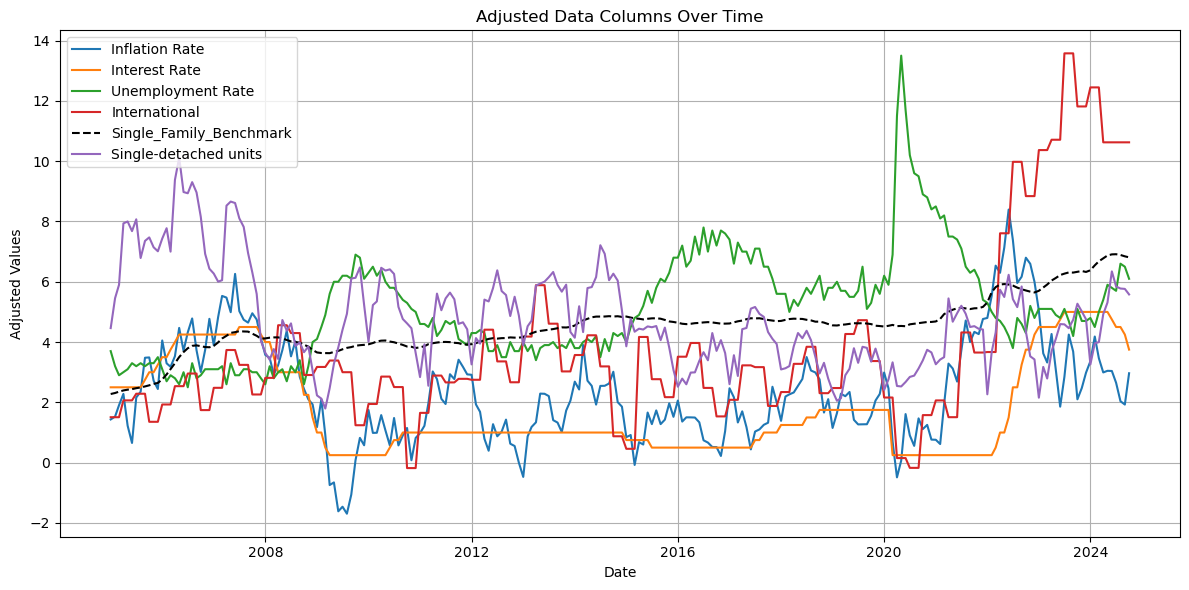

In [20]:
# Plot Adjusted Data

line_styles = {
    'Single_Family_Benchmark': 'k--'
}

fig, ax1 = plt.subplots(figsize=(12, 6))

for column in columns_to_plot:
    if column in line_styles:
        ax1.plot(df_adjusted['Date'], df_adjusted[column], line_styles[column], label=column)
    else:
        ax1.plot(df_adjusted['Date'], df_adjusted[column], label=column)

ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Values')
ax1.legend(loc='upper left')
plt.grid(True)
plt.title('Adjusted Data Columns Over Time')
plt.tight_layout()
plt.show()

**Conclusions:** The graphs reveal the dependence of Single_Family_Benchmark prices on the level of international migration to the province, inflation, and the number of real estate units that began construction, while the interest rate has virtually no impact on the price.

In [21]:
from xgboost import XGBClassifier
model = XGBClassifier(tree_method='gpu_hist')

In [ ]:
predictors = merged_df.drop(columns=[
    'Date',
    'Interest Rate',
    'Average exchange rate',
    'GDP Change (%)',
    'Single_Family_Benchmark',
    'Two_Storey_Benchmark',
    'Apartment_Benchmark',
    'One_Storey_Benchmark',
    'Townhouse_Benchmark'
])

targets = merged_df[
    ['Single_Family_Benchmark',
     'Two_Storey_Benchmark',
     'Apartment_Benchmark',
     'One_Storey_Benchmark',
     'Townhouse_Benchmark']
]

X_train, X_test, y_train, y_test = train_test_split(
    predictors, targets, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
overall_mse = mean_squared_error(y_test, y_pred)
model_performance = {
    "Mean Squared Error (per target)": mse,
    "Overall Mean Squared Error": overall_mse
}

new_data = pd.DataFrame({
    'Inflation Rate': [3.15],
    #'Interest Rate': [0.25],
    #'GDP Change (%)': [3],
    #'Average exchange rate': [1.22],
    'Unemployment Rate': [7.0],
    'International': [2500],
    'Interprovincial': [0],
    'Apartment and other unit types': [1130],
    'Row units': [320],
    'Semi-detached units': [300],
    'Single-detached units': [1000]
})

new_data_scaled = scaler.transform(new_data)
predicted_prices = model.predict(new_data_scaled)
print(f'Predicted Prices: {predicted_prices}')
print(model_performance)

Predicted Prices: [[494252.60547232 529553.50079163 255794.53342843 432187.68726083
  325109.90869135]]
{'Mean Squared Error (per target)': array([5.19892507e+08, 5.37686462e+08, 1.46177040e+08, 4.23184657e+08,
       1.93222236e+08]), 'Overall Mean Squared Error': 364032580.3121065}
